# Решения по удержанию клиентов в интернет-магазине «В один клик»

Этот проект поможет интернет-магазину удержать активность постоянных покупателей на сайте с помощью персонализированных предложений. 

**План действий**
- провести исследовательский анализ, чтобы понять, чем отличаются активные клиенты от тех, чья активность снижается.
- построить модель, чтобы узнать вероятности клиента принадлежать к сегменту снижающих активность; получить оценку важности признаков, что позволит уточнить выводы из исследовательского анализа.
- понять, какую группу-сегмент пользователей стоит удерживать в первую очередь и как именно.

**Описание данных**

Для анализа и обучения моделей мы будем использовать 4 датасета:
1. market_file.csv (df_customers) - содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. market_money.csv (df_money) - данные о выручке, которую получает магазин с покупателя за период взаимодействия с сайтом.
3. market_time.csv (df_time) - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
4. money.csv (df_monthly_profit) - данные о среднемесячной прибыли продавца за последние 3 месяца с каждого покупателя.

In [ ]:
!pip install scikit-learn==1.1.3 -q

In [ ]:
!pip install shap -q

## Знакомство с данными

Загружаем данные

In [ ]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap
from sklearn.inspection import permutation_importance

In [ ]:
try:
    df_customers = pd.read_csv('/datasets/market_file.csv')
    print("Данные успешно загружены")
    display(df_customers.head())
    df_customers.info()
    
except:
    print("Ошибка загрузки данных")

Данные успешно загружены


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [ ]:
try:
    df_money = pd.read_csv('/datasets/market_money.csv')
    print("Данные успешно загружены")
    display(df_money.head())
    df_money.info()
    
except:
    print("Ошибка загрузки данных")

Данные успешно загружены


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [ ]:
try:
    df_time = pd.read_csv('/datasets/market_time.csv')
    print("Данные успешно загружены")
    display(df_time.head())
    df_time.info()
    
except:
    print("Ошибка загрузки данных")

Данные успешно загружены


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [ ]:
try:
    df_monthly_profit = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
    print("Данные успешно загружены")
    display(df_monthly_profit.head())
    df_monthly_profit.info()
    
except:
    print("Ошибка загрузки данных")

Данные успешно загружены


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Что мы видим при первом знакомстве с данными:

- названия столбцов не унифицированы: где-то используются нижние подчеркивания, где-то нет, используется разный регистр;
- типы данных соответствуют содержанию;
- пропусков нет.

## Предобработка данных

### Названия колонок

Унифицируем названия колонок.

In [ ]:
df_customers.columns = df_customers.columns.str.lower().str.replace(' ', '_').str.replace(',', '_').str.replace('__', '_')

display(df_customers.head())

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [ ]:
df_money.columns = df_money.columns.str.lower()

display(df_money.head())

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [ ]:
df_time.columns = df_time.columns.str.lower()

display(df_time.head())

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [ ]:
df_monthly_profit.columns = df_monthly_profit.columns.str.lower()

display(df_monthly_profit.head())

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Неявные дубли

In [ ]:
# проверим написание категориальных переменных на наличие неявных дублей в df_customers
print(df_customers.groupby('покупательская_активность')['id'].count().sort_values())
print(df_customers.groupby('тип_сервиса')['id'].count().sort_values())
print(df_customers.groupby('разрешить_сообщать')['id'].count().sort_values())
print(df_customers.groupby('популярная_категория')['id'].count().sort_values())

покупательская_активность
Снизилась          498
Прежний уровень    802
Name: id, dtype: int64
тип_сервиса
стандартт     10
премиум      376
стандарт     914
Name: id, dtype: int64
разрешить_сообщать
нет    338
да     962
Name: id, dtype: int64
популярная_категория
Кухонная посуда                         138
Мелкая бытовая техника и электроника    174
Техника для красоты и здоровья          184
Косметика и аксесуары                   223
Домашний текстиль                       251
Товары для детей                        330
Name: id, dtype: int64


In [ ]:
# проверим написание категориальных переменных на наличие неявных дублей в df_money
print(df_money.groupby('период')['id'].count().sort_values())

период
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1300
Name: id, dtype: int64


In [ ]:
# проверим написание категориальных переменных на наличие неявных дублей в df_customers
print(df_time.groupby('период')['id'].count().sort_values())

период
предыдцщий_месяц    1300
текущий_месяц       1300
Name: id, dtype: int64


Обнаружили неявные дубли в датафрейме df_customers (написание "стандартт" и "стандарт").

Плюс есть явная опечатка в датафреймах df_time ("предыдцщий_месяц") и ("препредыдущий_месяц")

In [ ]:
# устраняем неявные дубли и опечатки в написании переменных
df_customers['тип_сервиса'] = df_customers['тип_сервиса'].replace('стандартт', 'стандарт')
print(df_customers.groupby('тип_сервиса')['тип_сервиса'].count().sort_values())

df_money['период'] = df_money['период'].replace('препредыдущий_месяц', 'предпредыдущий_месяц')
print(df_money.groupby('период')['период'].count().sort_values())

df_time['период'] = df_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
print(df_time.groupby('период')['период'].count().sort_values())

тип_сервиса
премиум     376
стандарт    924
Name: тип_сервиса, dtype: int64
период
предпредыдущий_месяц    1300
предыдущий_месяц        1300
текущий_месяц           1300
Name: период, dtype: int64
период
предыдущий_месяц    1300
текущий_месяц       1300
Name: период, dtype: int64


### Явные дубли

In [ ]:
# проверяем данные на наличие дубликатов
print('Дубликатов в df_customers', df_customers.duplicated().sum())
print('Дубликатов в df_money', df_money.duplicated().sum())
print('Дубликатов в df_time', df_time.duplicated().sum())
print('Дубликатов в df_monthly_profit', df_monthly_profit.duplicated().sum())

Дубликатов в df_customers 0
Дубликатов в df_money 0
Дубликатов в df_time 0
Дубликатов в df_monthly_profit 0


Дубликатов нет.

**Что сделали:**
- привели названия столбцов к общему виду;
- удалили неявные дубликаты;
- исправили опечатки в названиях переменных.

## Исследовательский анализ данных

### Анализ датасета df_customers

**Количественные данные**

In [ ]:
df_customers.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


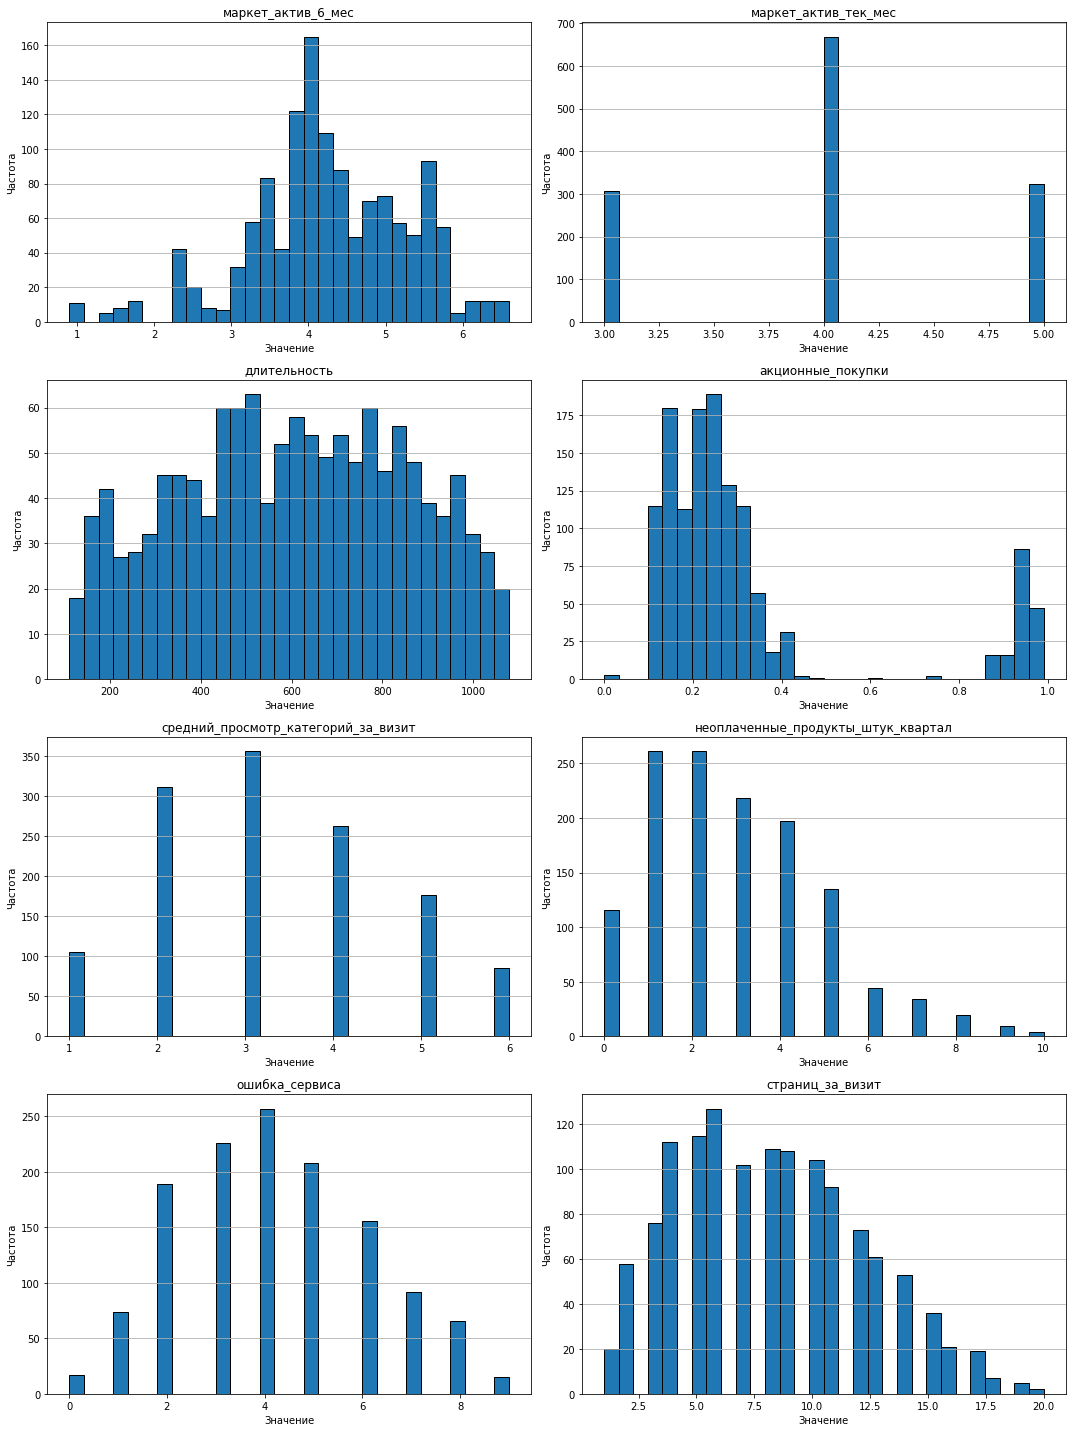

In [ ]:
# построим графики по общим данным
column_names = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса', 
    'страниц_за_визит'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

axes = axes.flatten()

for i, column in enumerate(column_names):
    ax = axes[i]
    ax.hist(df_customers[column], bins=30, edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

**Исходя из графиков и описания количественных данных, мы видим:**
1. маркет_актив_6_мес - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев.

Обращают на себя вимание длинный левый хвост графика (самые низкие значения 0,9-3). С этой аудиторией почти не коммуницировали.
Распределение почти симметрично, немного смещено вправо. Среднее (4.25) и медиана (4.2) находятся близко друг к другу. 

2. маркет_актив_тек_мес - количество маркетинговых коммуникаций в текущем месяце.

Больше всего было клиентов с 4 коммуникациями (мода), меньше всего — с 3 и 5.

3. длительность - показывает, сколько дней прошло с момента регистрации покупателя на сайте.

За последние 600 дней видим 3 всплеска в регистрациях. Их появление связано, скорее всего, с маркетинговой активностью. Но это не сильно влияет на распределение: оно практически равномерное (медиана 606, среднее 602).

4. акционные_покупки - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

Видим 2 всплеска в данных - это бимодальное распределение. Тут можно говорить о двух категориях пользователей: 1) покупают в основном только по акции (0.8-1); 2) обращают на акции не так много внимания. Так происходит из-за того, что маркетинговая коммуникация осуществляется точечно: если бы скидки предлагались всем, то распределение стремилось бы к нормальному.

Распределения на графиках 5-8 дискретное.

5. средний_просмотр_категорий_за_визит - сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

Чаще всего просматривают 3 категории за визит (мода). Наименее типичны значения 1 и 6

6. неоплаченные_продукты_штук_квартал - общее число неоплаченных товаров в корзине за последние 3 месяца.

Видим длинный хвост справа. Распределение немного смещено влево (медиана 3, среднее 2.8). Чаще всего пользователи оставляют 1-2 товара неоплаченными (мода). Однако длинный хвост вправо показывает, что существует небольшая группа людей, оставляющих в корзине до 10 товаров.

7. ошибка_сервиса - число сбоев, которые коснулись покупателя во время посещения сайта за последние 3 месяца.

Чаще всего пользователи сталкиваются с 4 ошибками (мода). Случаи, когда ошибок нет совсем (0) или очень много (9), — крайне редки.

8. страниц_за_визит - реднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Пик находится в районе 6-7 страниц за визит — это самое типичное поведение. Однако наличие пользователей, которые просматривают 15-20 и более страниц, создает "хвост" справа. Это приводит к тому, что среднее количество страниц за визит немного больше, чем медианное (8.18 VS 8)

In [ ]:
# разделим id клиентов по категориям покупательской активности
activ_castomers_df = df_customers[df_customers['покупательская_активность'] == 'Прежний уровень']
not_so_activ_castomers_df = df_customers[df_customers['покупательская_активность'] == 'Снизилась']

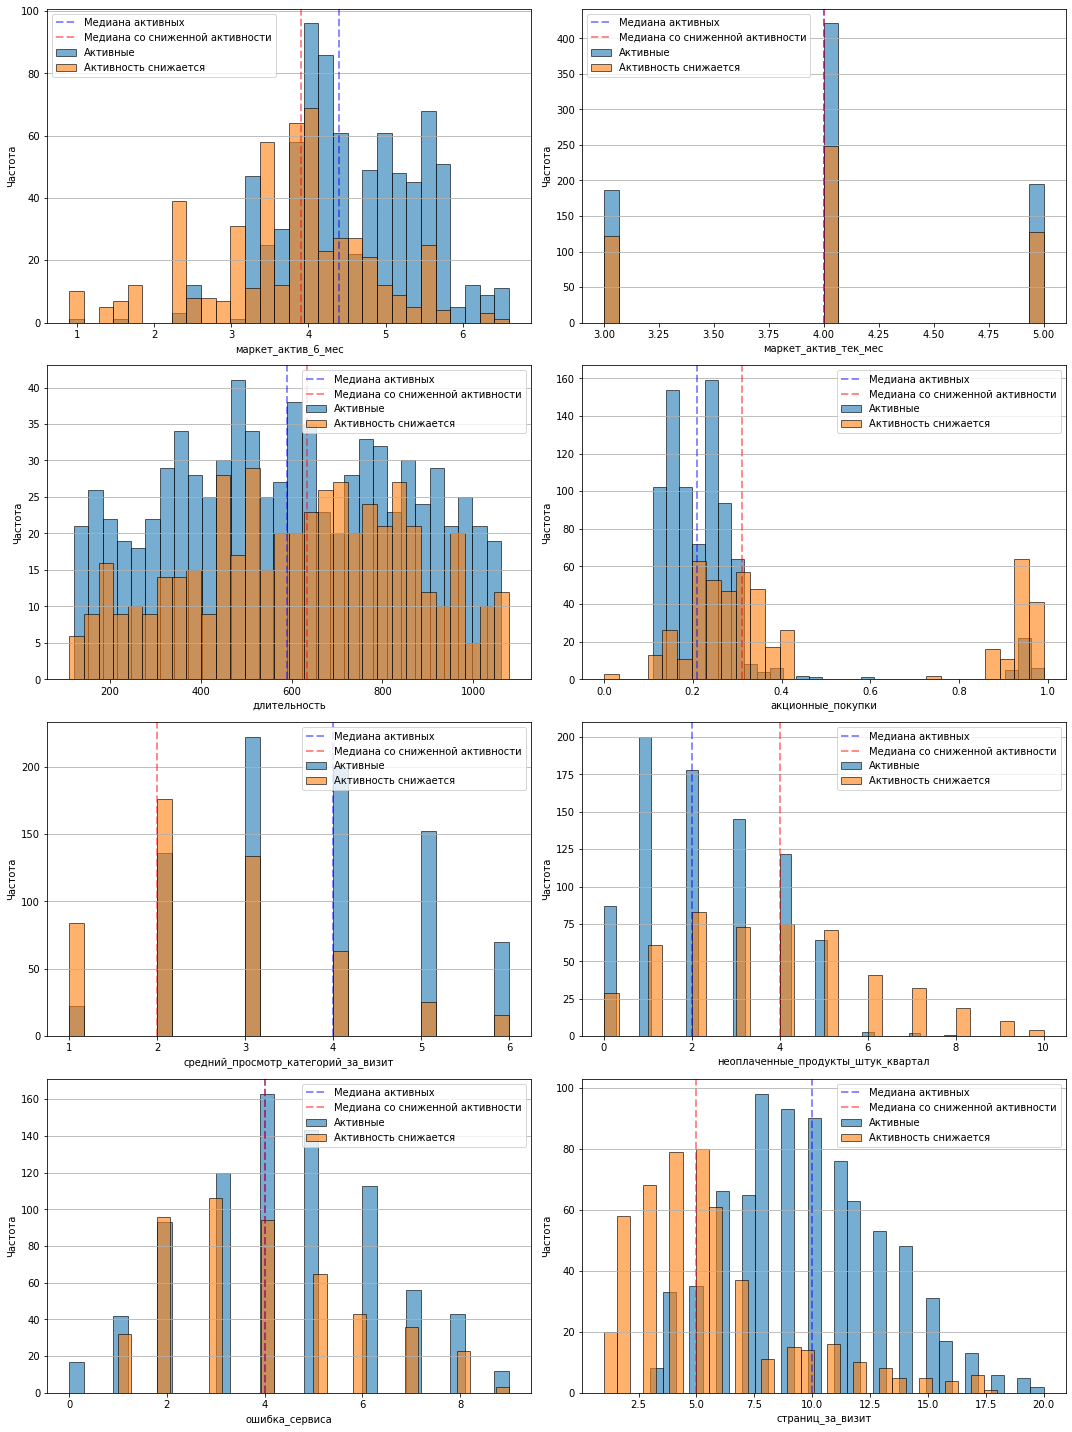

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))

axes = axes.flatten()

for i, column in enumerate(column_names):
    ax = axes[i]
    ax.hist(activ_castomers_df[column], 
            bins=30, 
            edgecolor='black', 
            alpha=0.6, 
            label='Активные')
    ax.hist(not_so_activ_castomers_df[column], 
            bins=30, 
            edgecolor='black', 
            alpha=0.6, 
            label='Активность снижается')
    ax.axvline(activ_castomers_df[column].median(), 
               color='blue', 
               alpha=0.45, 
               linestyle='--', 
               linewidth=2, 
               label=f'Медиана активных')
    ax.axvline(not_so_activ_castomers_df[column].median(), 
               color='red', 
               alpha=0.45, 
               linestyle='--', 
               linewidth=2, 
               label=f'Медиана со сниженной активности')
    ax.set_xlabel(column)
    ax.set_ylabel('Частота')
    ax.grid(axis='y')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
display('Данные по активным пользователям', activ_castomers_df.describe())

display('Данные по пользователям со сниженной активностью', not_so_activ_castomers_df.describe())

'Данные по активным пользователям'

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,216237.761845,4.570075,4.011222,590.730673,0.238367,3.665835,2.293017,4.335411,9.796758
std,246.221370,0.848618,0.689586,255.330179,0.160599,1.277112,1.508255,1.979538,3.376846
min,215748.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,3.000000
25%,216046.250000,4.000000,4.000000,382.500000,0.150000,3.000000,1.000000,3.000000,7.000000
50%,216246.500000,4.400000,4.000000,590.000000,0.210000,4.000000,2.000000,4.000000,10.000000
75%,216446.750000,5.275000,4.000000,798.750000,0.260000,5.000000,3.000000,6.000000,12.000000
max,216647.000000,6.600000,5.000000,1061.000000,0.990000,6.000000,8.000000,9.000000,20.000000


'Данные по пользователям со сниженной активностью'

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,215610.572289,3.744378,4.012048,619.883534,0.450964,2.632530,3.720884,3.943775,5.568273
std,165.843214,1.053374,0.709135,239.940818,0.306011,1.229871,2.287312,1.892709,3.454265
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,215472.250000,3.100000,4.000000,449.000000,0.240000,2.000000,2.000000,2.000000,3.000000
50%,215596.500000,3.900000,4.000000,634.500000,0.310000,2.000000,4.000000,4.000000,5.000000
75%,215720.750000,4.400000,5.000000,811.000000,0.890000,3.000000,5.000000,5.000000,7.000000
max,215941.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,18.000000


**Выводы по сравнению сегмента активных пользователей с теми, чья активность снижена:**
1. Видно, что маркетинговая активность за последние 6 месяцев по отношению к неактивным клиентам снижена (медиана 3.9 VS 4.4).
2. По длительности с момента регистрации видно, что неактивные клиенты - это "старички", те, кто зарегистрировался на сайте раньше (медиана 634,5 VS 590).
3. Среди неактивных пользователей доля любителей акций значительно больше.
4. Вовлеченность неактивных пользователей в контент сайта в 2 раза ниже, чем у активных пользователей (медиана просмотра категорий за визит 2 VS 4, страниц за визит 5 VS 10).
5. Количество брошенных в корзине товаров тоже в среднем в 2 раза больше у неактивных клиентов (медиана 4 VS 2).
6. По количеству ошибок сервиса большой разницы нет, распределение признака у неактивных пользователей чуть более асиметрично, смещено влево.

**Категориальные данные**

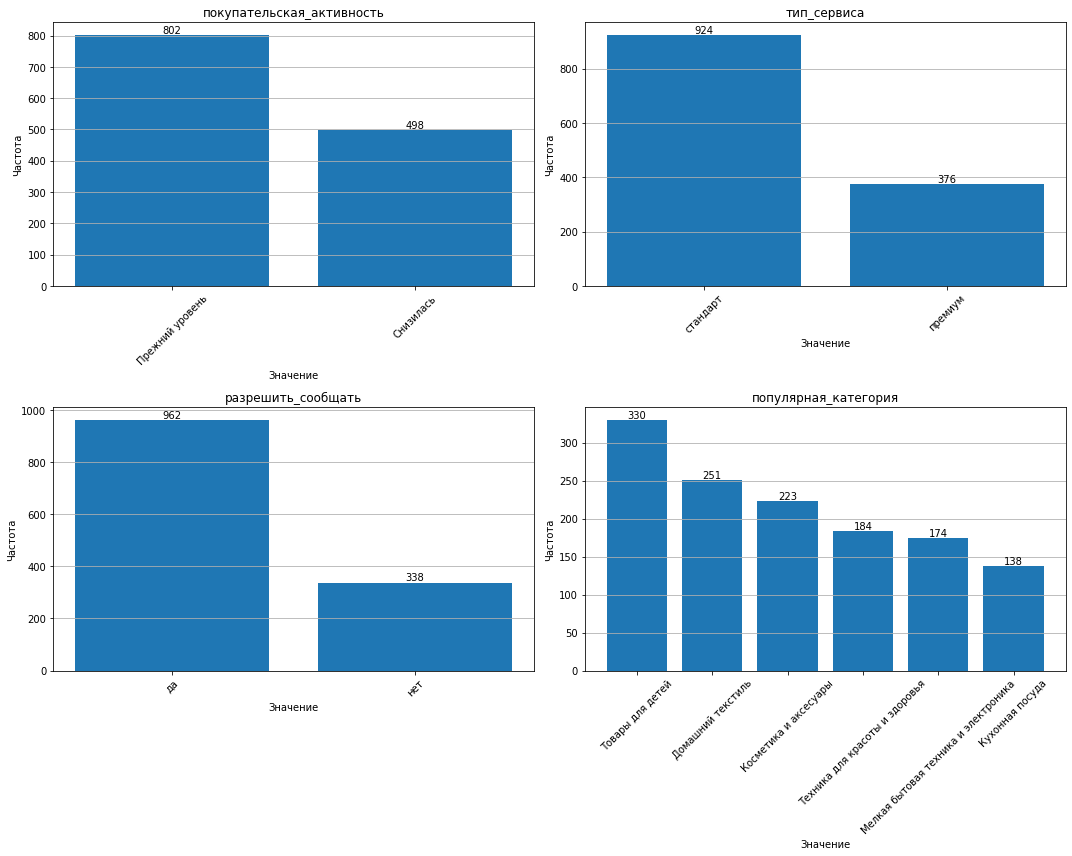

In [ ]:
column_names_cat = ['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axes = axes.flatten()

for i, column in enumerate(column_names_cat):
    ax = axes[i]
    bar_data = df_customers[column].value_counts()
    ax.bar(bar_data.index, bar_data.values)
    for index, value in zip(bar_data.index, bar_data.values):
        ax.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
    ax.set_title(column)
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')
    ax.tick_params(axis='x', labelrotation=45)
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

На графиках видно, что во всех столбцах есть дисбаланс классов. Это связано со спецификой данных: вполне логично, что покупателей с прежним уровнем активности больше, чем со сниженным (но сегмент довольно большой - 38%), а пользователей с премиум-подпиской меньше (всего 29%), чем обычных. Необычным можно посчитать тот факт, что большая часть пользователей разрешила присылать маркетинговые сообщения, тк обычно люди не любят, когда их беспокоят. Скорее всего, маркетинговые коммуникации выстроены грамотно, клиентов не заваливают спамом. Либо рассылку предложений включают автоматически с другими оповещениями. Распределение по категориям тоже можно считать вполне закономерным: "Товары для детей" - наиболее популярная категория, "Кухонная посуда" - наименее.

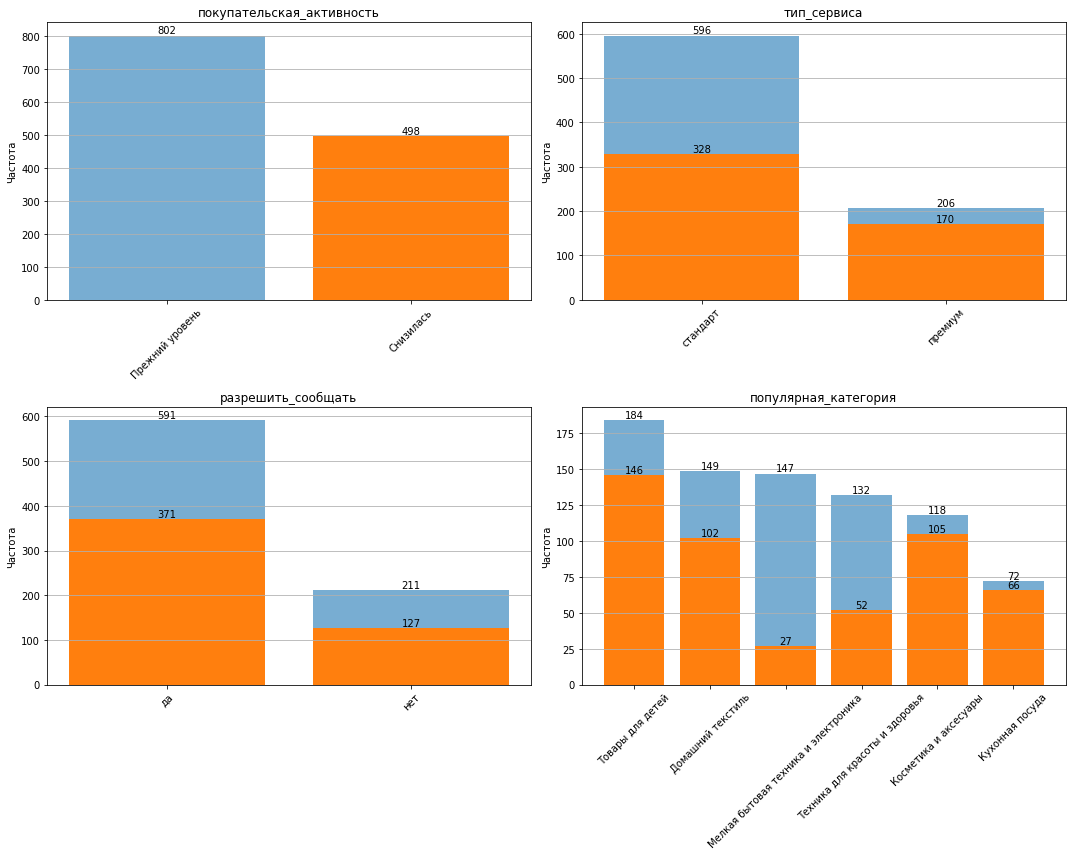

In [ ]:
# построим график для сравнения сегментов активных пользователей и тех,чья активность снижается
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axes = axes.flatten()

for i, column in enumerate(column_names_cat):
    ax = axes[i]
    bar_data1 = activ_castomers_df[column].value_counts()
    bar_data2 = not_so_activ_castomers_df[column].value_counts()
    ax.bar(bar_data1.index, bar_data1.values, alpha=0.6)
    ax.bar(bar_data2.index, bar_data2.values)
    for index, value in zip(bar_data1.index, bar_data1.values):
        ax.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
    for index, value in zip(bar_data2.index, bar_data2.values):
        ax.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
    ax.set_title(column)
    ax.set_ylabel('Частота')
    ax.tick_params(axis='x', labelrotation=45)
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

**Выводы по сравнению сегмента активных пользователей с теми, чья активность снижена:**
1. Доля обладателей премиум подписки гораздо выше среди неактивных клиентов (34% VS 26%).
2. Распределение по популярным категориям тоже различаются: хотя "Товары для детей" - самая популярная категория для обоих сегментов, наименее популярная у неактивных - "Мелкая бытовая техника", хотя у активных она занимает 3 место по популярности. "Техника для красоты и здоровья" тоже не пользуется популярностью у неактивных пользователей.

### Анализ датасета df_money

**Количественные данные**

In [ ]:
df_money.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


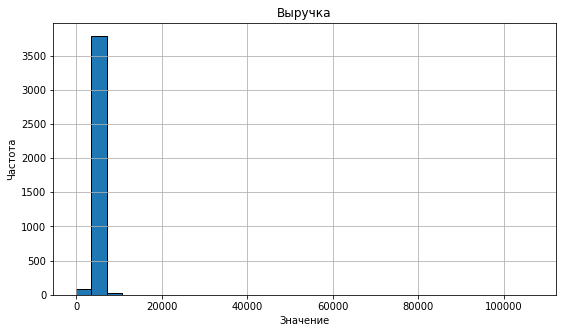

In [ ]:
# построим график по столбцу 'выручка'
plt.figure(figsize=(9, 5))
plt.hist(df_money['выручка'], bins=30, edgecolor='black')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Выручка')
plt.grid()
plt.show()

В данных есть выбросы - это максимальное значение 106862.2 и минимальное 0. Их нужно удалить.

In [ ]:
# удаляем выбросы
values_to_drop = [106862.2, 0]

display(df_money['выручка'].value_counts().sort_index().tail())
display(df_money['выручка'].value_counts().sort_index().head())
df_money = df_money[~df_money['выручка'].isin(values_to_drop)]
display(df_money['выручка'].value_counts().sort_index().tail())
display(df_money['выручка'].value_counts().sort_index().head())

7547.8      1
7557.0      1
7605.3      1
7799.4      1
106862.2    1
Name: выручка, dtype: int64

0.0       6
2758.7    1
2890.0    1
2909.0    1
2952.2    1
Name: выручка, dtype: int64

7467.9    1
7547.8    1
7557.0    1
7605.3    1
7799.4    1
Name: выручка, dtype: int64

2758.7    1
2890.0    1
2909.0    1
2952.2    1
2960.0    1
Name: выручка, dtype: int64

In [ ]:
df_money.describe()

,id,выручка
count,3893.000000,3893.000000
mean,215998.649371,5007.282918
std,374.681667,679.724898
min,215348.000000,2758.700000
25%,215674.000000,4592.000000
50%,215999.000000,4959.000000
75%,216323.000000,5363.000000
max,216647.000000,7799.400000


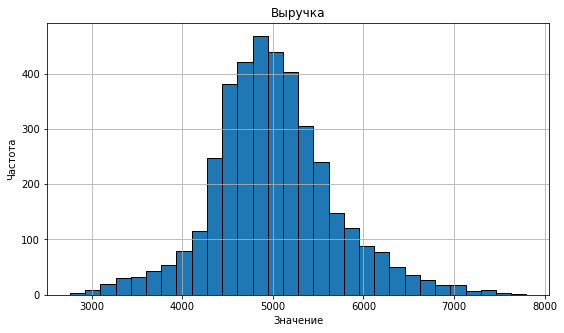

In [ ]:
# построим график по столбцу 'выручка' еще раз
plt.figure(figsize=(9, 5))
plt.hist(df_money['выручка'], bins=30, edgecolor='black')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Выручка')
plt.grid()
plt.show()

Данные по общей выручке за предыдущи и текущий месяца распределены практически нормально, есть небольшое смещение вправо (среднее 5007.4 > медианы 4959) за счет более длинного правого хвоста - это клиенты, которые тратят в 1.5 раза больше, чем в среднем. Эта аудитория представляет наибольший интерес для маркетинговых кампаний.

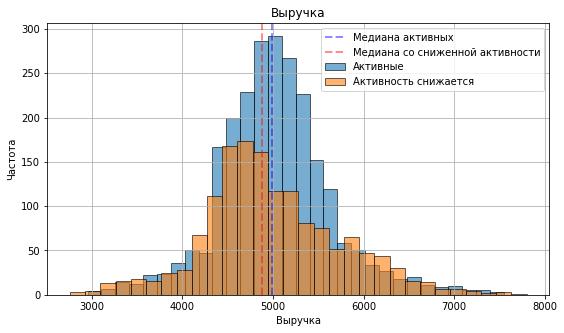

In [ ]:
# построим график по столбцу 'выручка' с разбиением по категориям покупательской активности

plt.figure(figsize=(9, 5))
plt.hist(df_money['выручка'][df_money['id'].isin(activ_castomers_df['id'])], 
         bins=30, 
         edgecolor='black', 
         alpha=0.6, 
         label='Активные')
plt.hist(df_money['выручка'][df_money['id'].isin(not_so_activ_castomers_df['id'])], 
         bins=30, 
         edgecolor='black', 
         alpha=0.6, 
         label='Активность снижается')
plt.axvline(df_money['выручка'][df_money['id'].isin(activ_castomers_df['id'])].median(), 
         color='blue', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана активных')
plt.axvline(df_money['выручка'][df_money['id'].isin(not_so_activ_castomers_df['id'])].median(), 
         color='red', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана со сниженной активности')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Выручка')
plt.legend()
plt.grid()
plt.show()

У клиентов со снижающейся активностью медиана по выручке меньше, чем у активных. Их график имеет бОльшую асимметрию.

**Категориальные данные**

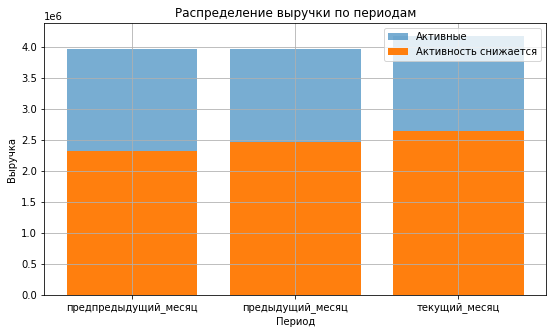

In [ ]:
# построим график по прибыли с учетом периодов
active_money_df = df_money[df_money['id'].isin(activ_castomers_df['id'])]
not_so_active_money_df = df_money[df_money['id'].isin(not_so_activ_castomers_df['id'])]

period_active = active_money_df.groupby('период')['выручка'].sum()
period_not_so_active = not_so_active_money_df.groupby('период')['выручка'].sum()

plt.figure(figsize=(9, 5))
plt.bar(period_active.index, period_active.values, alpha=0.6, label='Активные')
plt.bar(period_not_so_active.index, period_not_so_active.values, label='Активность снижается')
plt.xlabel('Период')
plt.ylabel('Выручка')
plt.title('Распределение выручки по периодам')
plt.grid()
plt.legend()
plt.show()

В текущем месяце выручка выросла в обоих сегментах. До этого рост наблюдался только у клиентов со снижающейся активностью.

### Анализ датасета df_time

**Количественные данные**

In [ ]:
df_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


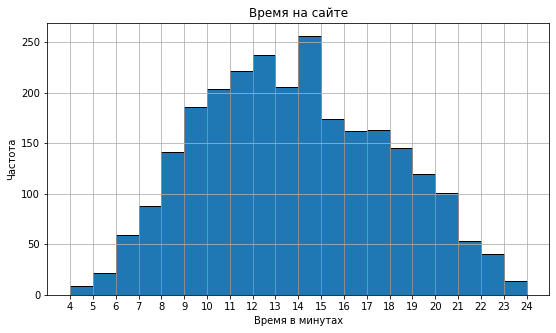

In [ ]:
# построим график по столбцу 'минут'
min_val = int(df_time['минут'].min())
max_val = int(df_time['минут'].max()) + 2

bin_edges = np.arange(min_val, max_val, 1)

plt.figure(figsize=(9, 5))
plt.hist(df_time['минут'], bins=bin_edges, edgecolor='black')
plt.xlabel('Время в минутах')
plt.ylabel('Частота')
plt.title('Время на сайте')
plt.grid()
plt.xticks(bin_edges)
plt.show()

Распределение времени на сайте практически нормальное, с небольшим смещением вправо (среднее 13.3 > медианы 13) за счет чуть более длинного правого хвоста. Обычно пользователи проводят на сайте от 10 до 16 минут. Есть аудитория наименее вовлеченных пользователей (4-6 минут) и наиболее вовлеченных (20-23 минуты). 

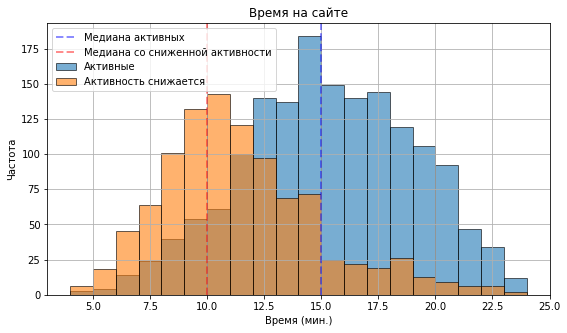

In [ ]:
# построим график по столбцу 'минут' с разбиением по категориям покупательской активности
active_time_df = df_time[df_time['id'].isin(activ_castomers_df['id'])]
not_so_active_time_df = df_time[df_time['id'].isin(not_so_activ_castomers_df['id'])]

min_val = int(df_time['минут'].min())
max_val = int(df_time['минут'].max()) + 2

bin_edges = np.arange(min_val, max_val, 1)

plt.figure(figsize=(9, 5))
plt.hist(active_time_df['минут'], 
         bins=bin_edges, 
         edgecolor='black', 
         alpha=0.6, 
         label='Активные')
plt.hist(not_so_active_time_df['минут'], 
         bins=bin_edges, 
         edgecolor='black', 
         alpha=0.6, 
         label='Активность снижается')
plt.axvline(active_time_df['минут'].median(), 
         color='blue', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана активных')
plt.axvline(not_so_active_time_df['минут'].median(), 
         color='red', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана со сниженной активности')
plt.xlabel('Время (мин.)')
plt.ylabel('Частота')
plt.title('Время на сайте')
plt.legend()
plt.grid()
plt.show()

По графику видно что неактивные пользователи тратят в среднем на треть меньше времени на сайте, чем активные (медиана 10 VS 15). 

**Категориальные данные**

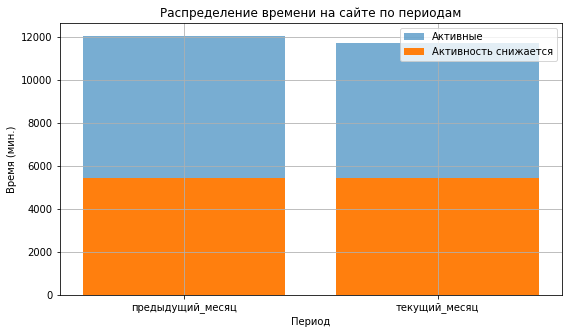

In [ ]:
# построим график по времени на сайте с учетом периодов

period_time_active = active_time_df.groupby('период')['минут'].sum()
period_time_not_so_active = not_so_active_time_df.groupby('период')['минут'].sum()

plt.figure(figsize=(9, 5))
plt.bar(period_time_active.index, period_time_active.values, alpha=0.6, label='Активные')
plt.bar(period_time_not_so_active.index, period_time_not_so_active.values, label='Активность снижается')
plt.xlabel('Период')
plt.ylabel('Время (мин.)')
plt.title('Распределение времени на сайте по периодам')
plt.grid()
plt.legend()
plt.show()


Активные пользователи стали проводить меньше времени на сайте в текущем месяце.

### Анализ датасета df_monthly_profit

In [ ]:
df_monthly_profit.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


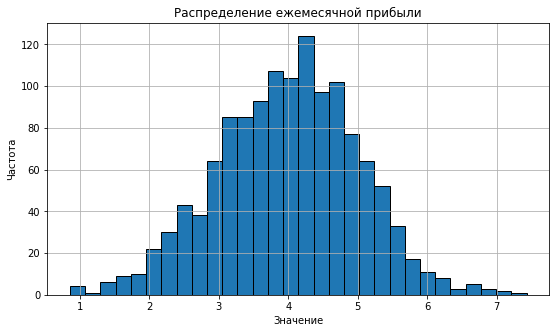

In [ ]:
# построим график по столбцу 'прибыль'
plt.figure(figsize=(9, 5))
plt.hist(df_monthly_profit['прибыль'], bins=30, edgecolor='black')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение ежемесячной прибыли')
plt.grid()
plt.show()

Распределение нормальное и немного смещено влево (среднее 3.997 < медианы 4.045). Большая часть клиентов приносит в месяц в среднем 3.3-4.7 в условных единицах. 

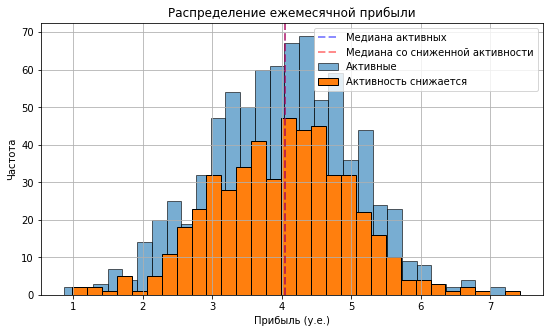

In [ ]:
# построим график по столбцу 'прибыль' с разбиением по категориям покупательской активности
active_profit_df = df_monthly_profit[df_monthly_profit['id'].isin(activ_castomers_df['id'])]
not_so_active_profit_df = df_monthly_profit[df_monthly_profit['id'].isin(not_so_activ_castomers_df['id'])]

plt.figure(figsize=(9, 5))
plt.hist(active_profit_df['прибыль'], 
         bins=30, 
         edgecolor='black', 
         alpha=0.6, 
         label='Активные')
plt.hist(not_so_active_profit_df['прибыль'], 
         bins=30, 
         edgecolor='black', 
         label='Активность снижается')
plt.axvline(active_profit_df['прибыль'].median(), 
         color='blue', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана активных')
plt.axvline(not_so_active_profit_df['прибыль'].median(), 
         color='red', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана со сниженной активности')
plt.xlabel('Прибыль (у.е.)')
plt.ylabel('Частота')
plt.title('Распределение ежемесячной прибыли')
plt.legend()
plt.grid()
plt.show()

Прибыль обе категории клиентов приносят сравнимую (медиана и там, и там примерно 4). Именно поэтому так важно удержать тех, кто теряет активность.

### Выводы по итогам анализа

На основе исследовательского анализа данных мы можем составить детальный портрет клиента, чья покупательская активность снижается. Эти клиенты составляют значительную долю — 38% от всей базы, и их удержание важно для бизнеса.

Выявлены следующие **особенности клиентов** из сегмента со сниженной активностью:
1. Они не вовлечены - это наиболее яркая черта, которая прослеживается на нескольких признаках:
- время на сайте: проводят на сайте на 33% меньше времени (медиана 10 минут против 15 у активных).
- глубина просмотра: просматривают в 2 раза меньше страниц за визит (медиана 5 страниц против 10).
- широта интереса: изучают в 2 раза меньше товарных категорий за визит (медиана 2 категории против 4).

Эти клиенты взаимодействуют с сайтом поверхностно. Они либо не могут найти интересный контент, либо приходят с очень конкретной целью и не исследуют ассортимент.

2. Чувствительны к цене:
- часто покупают по акции (медиана доли от всех покупок 31% против 21%);
- бросают товары в корзине, возможно, в ожидании лучшей цены (оставляют в корзине в 2 раза больше неоплаченных товаров, чем активные).

3. "Старожилы" с премиум-подпиской:
- длительность с момента регистрации у них, в среднем, больше (медиана 634 дня на сайте против 590 у активных);
- доля обладателей премиум-подписки выше (34% против 26% у активных).

Необычное сочетание: как будто эта аудитория должна быть более лояльной и вовлеченной. Возможно, преимущества подписки для них уже неактуальны.

4. Финансово значимы для бизнеса:
- выручка меньше, чем у активных;
- прибыль примерно на том же уровне (медиана около 4.0 у.е. для обеих групп).

Именно поэтому удержание этого сегмента так важно.

Возможные **причины снижения активности** клиентов:
- недовольство ценой (брошенные товары, ожидание акций);
- недостаточная маркетинговая коммуникация (медиана коммуникаций за 6 мес. 3.9 против 4.4 у активных);
- невовлеченность из-за низкой заинтересованности в товарах/невозможности найти нужное/неудобного интерфейса;
- неэффективность премиум-подписки (не мотивирует быть вовлеченными и покупать).

## Объединение таблиц

При моделировании нам понадобятся данные из 3 датафреймов:
- df_customers;
- df_money;
- df_time.

Объединим их в один.

In [ ]:
# создадим сводную таблицу на базе df_money, чтобы подготовить ее к объединению
df_money_pivot = df_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
df_money_pivot.columns.name = None
df_money_pivot = df_money_pivot.reset_index()
df_money_pivot = df_money_pivot.rename(columns={
    'предыдущий_месяц': 'выручка_предыдущий_месяц',
    'предпредыдущий_месяц': 'выручка_предпредыдущий_месяц',
    'текущий_месяц': 'выручка_текущий_месяц'
})
display(df_money_pivot)

,id,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,NaN,NaN,3293.1
1,215349,4472.0,5216.0,4971.6
2,215350,4826.0,5457.5,5058.4
3,215351,4793.0,6158.0,6610.4
4,215352,4594.0,5807.5,5872.5
...,...,...,...,...
1295,216643,4704.0,3664.0,4741.7
1296,216644,5299.0,4729.0,5353.0
1297,216645,5334.0,5160.0,5139.2
1298,216646,4725.0,4923.0,5224.6


In [ ]:
# проверим данные на наличие пропусков
display(df_money_pivot.isna().sum())
display(df_money_pivot[
    (df_money_pivot['выручка_предпредыдущий_месяц'].isna()) | 
    (df_money_pivot['выручка_предыдущий_месяц'].isna()) | 
    (df_money_pivot['выручка_текущий_месяц'].isna())
])

id                              0
выручка_предпредыдущий_месяц    3
выручка_предыдущий_месяц        3
выручка_текущий_месяц           1
dtype: int64

,id,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,NaN,NaN,3293.1
9,215357,NaN,NaN,5986.3
11,215359,NaN,NaN,4735.0
32,215380,5051.0,6077.0,NaN


В данном случае пропуски, скорее всего, означают отсутствие выручки. Можем удалить строки с пропусками.

In [ ]:
# удаляем строки с пропусками
df_money_pivot = df_money_pivot.dropna()

display(df_money_pivot.isna().sum())
display(df_money_pivot)

id                              0
выручка_предпредыдущий_месяц    0
выручка_предыдущий_месяц        0
выручка_текущий_месяц           0
dtype: int64

,id,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
1,215349,4472.0,5216.0,4971.6
2,215350,4826.0,5457.5,5058.4
3,215351,4793.0,6158.0,6610.4
4,215352,4594.0,5807.5,5872.5
5,215353,5124.0,4738.5,5388.5
...,...,...,...,...
1295,216643,4704.0,3664.0,4741.7
1296,216644,5299.0,4729.0,5353.0
1297,216645,5334.0,5160.0,5139.2
1298,216646,4725.0,4923.0,5224.6


In [ ]:
# создадим сводную таблицу на базе df_time, чтобы подготовить ее к объединению
df_time_pivot = df_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum')
df_time_pivot.columns.name = None
df_time_pivot = df_time_pivot.reset_index()
df_time_pivot = df_time_pivot.rename(columns={
    'предыдущий_месяц': 'минут_предыдущий_месяц', 
    'текущий_месяц': 'минут_текущий_месяц'
})
display(df_time_pivot)

,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


In [ ]:
# проверим данные на наличие пропусков
display(df_time_pivot.isna().sum())

id                        0
минут_предыдущий_месяц    0
минут_текущий_месяц       0
dtype: int64

In [ ]:
# проверим df_customers на наличие пропусков
df_customers.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [ ]:
# объединим все таблицы в одну поэтапно
df_merged = df_customers.merge(df_money_pivot, on='id', how='inner')
df_merged = df_merged.merge(df_time_pivot, on='id', how='inner')

# устанавливаем id вместо индекса, чтобы потом соотнести вероятности и клиента
df_merged = df_merged.set_index('id')

display(df_merged)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,4741.7,14,7
216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5353.0,12,11
216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5139.2,12,18


In [ ]:
# проверим, есть ли пропуски
df_merged.isna().sum()

покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предпредыдущий_месяц           0
выручка_предыдущий_месяц               0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [ ]:
# проверим, есть ли дубли
df_merged.duplicated().sum()

11

In [ ]:
# удаляем дубликаты
df_merged = df_merged.drop_duplicates()

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1285 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1285 non-null   object 
 1   тип_сервиса                          1285 non-null   object 
 2   разрешить_сообщать                   1285 non-null   object 
 3   маркет_актив_6_мес                   1285 non-null   float64
 4   маркет_актив_тек_мес                 1285 non-null   int64  
 5   длительность                         1285 non-null   int64  
 6   акционные_покупки                    1285 non-null   float64
 7   популярная_категория                 1285 non-null   object 
 8   средний_просмотр_категорий_за_визит  1285 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1285 non-null   int64  
 10  ошибка_сервиса                       1285 non-null   int64  
 11  страниц_за_визит       

## Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 

In [ ]:
# построим мартицу корреляций
display(df_merged.corr())

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
маркет_актив_6_мес,1.000000,0.055421,-0.039495,-0.242393,0.205402,-0.163305,0.034161,0.317765,0.245637,0.022891,0.015832,0.288626,0.224284
маркет_актив_тек_мес,0.055421,1.000000,-0.135048,-0.007684,-0.021028,0.055808,0.085553,0.005742,-0.042310,-0.029521,-0.012343,0.009620,-0.069709
длительность,-0.039495,-0.135048,1.000000,0.008472,-0.054819,-0.089498,0.113023,-0.039360,-0.050508,0.009494,0.015699,-0.125488,0.095189
акционные_покупки,-0.242393,-0.007684,0.008472,1.000000,-0.174782,0.197016,-0.029475,-0.310045,-0.206903,-0.007196,0.013997,-0.273047,-0.222566
средний_просмотр_категорий_за_визит,0.205402,-0.021028,-0.054819,-0.174782,1.000000,-0.275063,0.004942,0.243975,0.141583,-0.044653,-0.077863,0.139552,0.228923
неоплаченные_продукты_штук_квартал,-0.163305,0.055808,-0.089498,0.197016,-0.275063,1.000000,-0.093051,-0.198137,-0.268555,-0.008378,0.037615,-0.186828,-0.214977
ошибка_сервиса,0.034161,0.085553,0.113023,-0.029475,0.004942,-0.093051,1.000000,0.088621,0.077439,0.039935,0.031230,0.187642,0.071394
страниц_за_визит,0.317765,0.005742,-0.039360,-0.310045,0.243975,-0.198137,0.088621,1.000000,0.294986,-0.040017,-0.030794,0.428801,0.257554
выручка_предпредыдущий_месяц,0.245637,-0.042310,-0.050508,-0.206903,0.141583,-0.268555,0.077439,0.294986,1.000000,0.324819,0.120728,0.350511,0.295629
выручка_предыдущий_месяц,0.022891,-0.029521,0.009494,-0.007196,-0.044653,-0.008378,0.039935,-0.040017,0.324819,1.000000,0.839768,-0.064978,-0.055179


Исходя из матрицы корреляций, между признаками почти нет сильной взаимосвязи. 

**Самые заметные корреляции (больше 0.4):**
- выручка_текущий_месяц и выручка_предыдущий_месяц: 0.840

Очень сильная положительная взаимосвязь. Логично, что клиенты, которые приносили много выручки в прошлом месяце, с высокой вероятностью принесут много и в текущем. Это говорит о стабильности доходности от клиентов.
- минут_предыдущий_месяц и страниц_за_визит: 0.429

Средняя положительная взаимосвязь. Чем больше пользователи проводили времени на сайте, тем больше страниц за один визит они просмотрели. Важно, что корреляция с признаком 'минут_текущий_месяц' и 'страниц_за_визит' уже не такая сильная (0.255). Это может говорить о том, что пользователи стали тратить больше времени не на просмотр страниц, а, например, на ожидание их загрузки.

**Слабые корреляции**
1. Положительные:
- минут_текущий_месяц и минут_предыдущий_месяц: 0.351 (пользователи сохраняют привычки по времени на сайте);
- страниц_за_визит и маркет_актив_6_мес: 0.318 (чем выше маркетинговая активность, тем больше глубина просмотра сайта);
- выручка_предпредыдущий_месяц и выручка_предыдущий_месяц: 0.325 (клиенты, которые приносили много выручки в прошлом месяце, с высокой вероятностью принесут много и в следующем)
- минут_предыдущий_месяц и маркет_актив_6_мес: 0.289 (такая же закономернось);
- минут_предыдущий_месяц и выручка_предпредыдущий месяц: 0.350 (более вовлеченные приносят больше выручки);
- выручка_предпредыдущий_месяц и страниц_за_визит: 0.295 (более вовлеченные приносят больше выручки);
- минут_текущий_месяц и страниц_за_визит: 0.258 (больше страниц - больше времени).

2. Отрицательные:
- акционные_покупки и страниц_за_визит: -0.310 (более вовлеченные клиенты реже покупают по акции);
- неоплаченные_продукты_штук и средний_просмотр_категорий_за_визит: -0.275 (более вовлеченные клиенты реже бросают корзину);
- минут_предыдущий_месяц и акционные_покупки: -0.273 (более вовлеченные клиенты реже покупают по акции).

**Выводы:**
1. Интересно, что id клиента имеет корреляцию со многими признаками (страниц_за_визит, минут_предыдущий_месяц, минут_текущий_месяц, маркет_актив_6_мес, акционные_покупки, неоплаченные_продукты_штук). Судя по всему id присваивались последовательно, и поведение новых клиентов отличается от поведения старых.
2. Любители скидок - это менее вовлеченные в контент сайта клиенты (обратная взаимосвязь с страниц_за_визит, минут_предыдущий_месяц, минут_текущий_месяц).
3. Более вовлеченные клиенты приносят больше выручки (но это видно только на примере предпредыдущего месяца).
4. Выручка последующего периода сильно коррелирует с выручкой предыдущего периода - это хорошая основа для прогнозирования.
5. Мультиколлинеарности между признаками нет, что хорошо для обучениянашей будущей модели.

## Моделирование

Для выбора оптимальной модели обучим 4 разных варианта:
- LogisticRegression,
- KNeighborsClassifier,
- DecisionTreeClassifier,
- SVC.

При этом протестируем 2 варианта кодирования категориальных признаков и 2 способа масштабирования.

In [ ]:
# установим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# разделим данные на тренировочную, валидационную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    df_merged.drop(['покупательская_активность'], axis=1),
    df_merged['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_merged['покупательская_активность']
)

X_train.shape, X_test.shape

# создаём списки с названиями признаков
cat_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
num_columns = ['маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса', 
    'страниц_за_визит',
    'выручка_предпредыдущий_месяц', 
    'выручка_предыдущий_месяц', 
    'выручка_текущий_месяц',
    'минут_предыдущий_месяц', 
    'минут_текущий_месяц'
]

# создаём пайплайн для подготовки признаков из списка cat_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)

# создаём пайплайн для подготовки признаков из списка cat_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('cat', ohe_pipe, cat_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
    
# создаем список гиперпараметров
param_grid = {
    'preprocessor__cat': [ohe_pipe, ord_pipe],
    'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    'models' : [
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        KNeighborsClassifier(),
        SVC(random_state=RANDOM_STATE, probability=True),
        LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
    ]
}
        
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                               

In [ ]:
# выведем таблицу с результатами
result = pd.DataFrame(randomized_search.cv_results_)
display(result)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_preprocessor__cat,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020046,0.008268,0.006865,0.000178,StandardScaler(),"(SimpleImputer(strategy='most_frequent'), OneH...",DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'prepr...",0.802112,0.782078,0.782648,0.783333,0.848611,0.799757,0.025563,8
1,0.015106,0.000193,0.006939,0.000096,MinMaxScaler(),"(SimpleImputer(strategy='most_frequent'), OneH...",DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'preproc...",0.802112,0.782078,0.782648,0.783333,0.848611,0.799757,0.025563,8
2,0.028364,0.035833,0.042059,0.041973,MinMaxScaler(),"(SimpleImputer(strategy='most_frequent'), OneH...",KNeighborsClassifier(),"{'preprocessor__num': MinMaxScaler(), 'preproc...",0.838958,0.881336,0.865696,0.847049,0.902373,0.867082,0.022991,7
3,0.014965,0.003597,0.006569,0.000242,StandardScaler(),"(SimpleImputer(strategy='most_frequent'), Ordi...","LogisticRegression(random_state=42, solver='li...","{'preprocessor__num': StandardScaler(), 'prepr...",0.894054,0.922489,0.874087,0.905208,0.912963,0.901760,0.016687,6
4,0.011351,0.000512,0.006033,0.000331,MinMaxScaler(),"(SimpleImputer(strategy='most_frequent'), OneH...","LogisticRegression(random_state=42, solver='li...","{'preprocessor__num': MinMaxScaler(), 'preproc...",0.900482,0.922831,0.880365,0.902894,0.913310,0.903976,0.014237,3
5,0.068992,0.001234,0.010034,0.000406,MinMaxScaler(),"(SimpleImputer(strategy='most_frequent'), Ordi...","SVC(probability=True, random_state=42)","{'preprocessor__num': MinMaxScaler(), 'preproc...",0.907140,0.913927,0.879795,0.896991,0.919444,0.903459,0.014004,4
6,0.075114,0.002314,0.010359,0.000291,StandardScaler(),"(SimpleImputer(strategy='most_frequent'), OneH...","SVC(probability=True, random_state=42)","{'preprocessor__num': StandardScaler(), 'prepr...",0.910009,0.913242,0.903311,0.896644,0.934028,0.911447,0.012653,1
7,0.076991,0.001707,0.010357,0.000244,MinMaxScaler(),"(SimpleImputer(strategy='most_frequent'), OneH...","SVC(probability=True, random_state=42)","{'preprocessor__num': MinMaxScaler(), 'preproc...",0.900712,0.915525,0.883904,0.904398,0.920602,0.905028,0.012790,2
8,0.015895,0.000425,0.006799,0.000482,StandardScaler(),"(SimpleImputer(strategy='most_frequent'), Ordi...",DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'prepr...",0.796660,0.793094,0.748116,0.759722,0.840278,0.787574,0.032321,10
9,0.012407,0.000538,0.006163,0.000273,MinMaxScaler(),"(SimpleImputer(strategy='most_frequent'), Ordi...","LogisticRegression(random_state=42, solver='li...","{'preprocessor__num': MinMaxScaler(), 'preproc...",0.893480,0.920890,0.877397,0.910648,0.909606,0.902405,0.015275,5


Вывод:
- Лучшая модель: SVC()
- Метрика лучшей модели на тренировочной выборке: 0.91
- Метрика ROC-AUC на тестовой выборке: 0.92

Метрика качества ROC-AUC была выбрана, так как учитывает эта метрика учитывает и полноту, и точность комплексно, а не по отдельности.

## Анализ важности признаков

Оценим важность признаков.

In [ ]:
# получаем лучший пайплайн, извлекаем из него пайплайн предобработки и модель
best_pipeline = randomized_search.best_estimator_
model = best_pipeline.named_steps['models']
preprocessor = best_pipeline.named_steps['preprocessor']

# преобразуем тренировочные данные
X_train_processed = preprocessor.transform(X_train)

# получаем названия столбцов после всех преобразований
feature_names = preprocessor.get_feature_names_out()


# создаем датафрейм, это поможет SHAP подписать оси на графике
X_train_processed_df = pd.DataFrame(
    best_pipeline.named_steps['preprocessor'].transform(X_train),
    columns=feature_names
)

display(X_train_processed_df.head())

,cat__тип_сервиса_стандарт,cat__разрешить_сообщать_нет,cat__популярная_категория_Косметика и аксесуары,cat__популярная_категория_Кухонная посуда,cat__популярная_категория_Мелкая бытовая техника и электроника,cat__популярная_категория_Техника для красоты и здоровья,cat__популярная_категория_Товары для детей,num__маркет_актив_6_мес,num__маркет_актив_тек_мес,num__длительность,num__акционные_покупки,num__средний_просмотр_категорий_за_визит,num__неоплаченные_продукты_штук_квартал,num__ошибка_сервиса,num__страниц_за_визит,num__выручка_предпредыдущий_месяц,num__выручка_предыдущий_месяц,num__выручка_текущий_месяц,num__минут_предыдущий_месяц,num__минут_текущий_месяц
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.950618,-0.029127,-0.499637,-0.481680,0.535987,-0.427512,0.402855,0.705633,0.985924,0.083645,0.051443,1.393517,-0.534722
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.161186,-1.431616,-0.172370,-0.162219,-0.201378,-1.415974,-0.111667,0.201722,1.257912,0.053461,-0.420812,0.886640,0.914444
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.345334,-1.431616,0.198799,-0.321949,0.535987,-1.415974,-0.626188,-1.058057,-0.607571,-0.055773,-0.519024,-1.394306,-1.017777
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.628246,1.373361,-0.132459,-0.162219,0.535987,1.055181,0.402855,-0.806102,-0.294193,0.573045,0.924167,-0.127114,1.397499
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.358544,-0.029127,-0.072593,0.117310,-0.938743,1.549412,-0.111667,-1.310013,0.264565,-2.615602,-2.568039,0.126324,-0.293194


  0%|          | 0/963 [00:00<?, ?it/s]

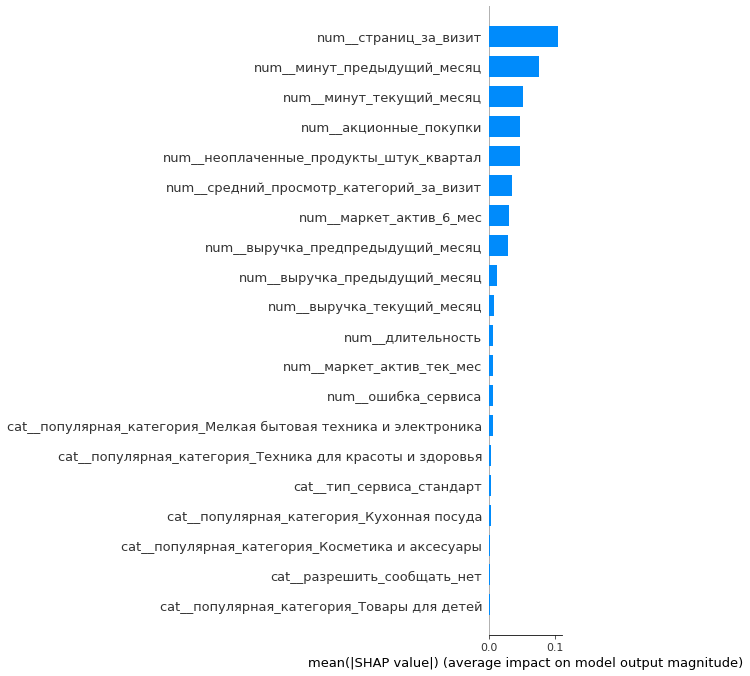

In [ ]:
# уменьшаем выборку для ускорения расчетов
X_train_processed_df_to_SHAP = shap.kmeans(X_train_processed_df, 30)

explainer = shap.KernelExplainer(model.predict_proba, X_train_processed_df_to_SHAP)
shap_values = explainer(X_train_processed_df)

# строим график
shap_values_class1 = shap_values[:, :, 1]
shap.summary_plot(shap_values_class1, X_train_processed_df, plot_type='bar', feature_names=feature_names, show=False)

**Наименее значимые признаки:**
- популярные категории
- маркетинговая активность в текущем месяце
- выручка предыдущий/текущий месяц


**Самые важные признаки:**
- страниц за визит: это ключевой показатель вовлеченности;
- минут предыдущий/текущий месяц: показывает активность на сайте;
- средний просмотр категорий за визит: насколько глубоко пользователь изучает ассортимент;
- акционные покупки: как  часто пользователь участвовал в акциях;
- неоплаченные покупки: сколько товаров клиент бросил в корзине неоплаченными.

Эти признаки связаны с поведенческой активностью и вовлеченностью пользователя.

**Как мы можем использовать эти данные**
1. При моделировании
- удаление наименеезначимых признаков: это позволит избежать переобучения модели, упростит ее и, возможно, улучшит качество.
- генерация новых признаков: например, можно посчитать разницу между прибылью в разных месяцах, чтобы зафиксировать динамику.
2. При принятии бизнес-решений
- увеличение вовлеченности пользователей с помощью рекомендательной системы/персонализации маркетинговой коммуникации/полезного контента.
- улучшение информирования об акциях для любителей скидок.

## Сегментация покупателей

Выполним сегментацию покупателей, используя результаты моделирования и данные о выручке покупателей.

Разделим аудиторию по 2 основным параметрам: 
- вероятность снижения активности (результат предсказания модели),
- прибыльность.

### Выделение сегмента

In [ ]:
# создадим датафрейм с вероятностями принадлежности к классу "активность снижается"
segmentation_df = pd.DataFrame(pd.concat([pd.Series(randomized_search.predict_proba(X_test)[:,1]), pd.Series(X_test.index)], axis = 1))
segmentation_df = segmentation_df.rename(columns={
    0: 'вероятность',
    1: 'id'
})

# добавим в него данные о выручке
money = df_money.groupby('id')['выручка'].sum()
segmentation_df = segmentation_df.merge(money, on='id', how='left')

display(segmentation_df)

,вероятность,id,выручка
0,0.098314,216600,13883.1
1,0.085935,216243,13583.6
2,0.975760,215737,15096.1
3,0.588317,216595,14396.9
4,0.226776,216259,14421.9
...,...,...,...
317,0.178365,216546,11766.9
318,0.078029,216238,15237.7
319,0.118738,215782,16971.4
320,0.095585,216063,13108.0


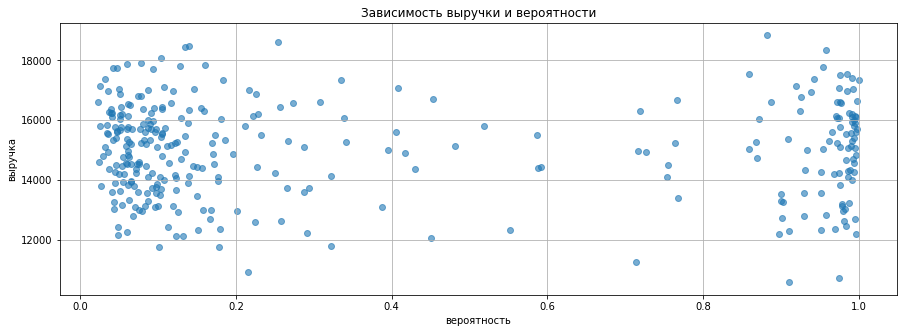

In [ ]:
# построим диаграмму рассеяния для выявления взаимозависимости выручки и вероятности отнесения в класс "снижающие активность"
plt.figure(figsize=(15, 5))
plt.scatter(segmentation_df['вероятность'], segmentation_df['выручка'], marker='o', alpha=0.6)
plt.xlabel('вероятность')
plt.ylabel('выручка')
plt.title('Зависимость выручки и вероятности')
plt.grid()
plt.show()

На графике заметны 2 категории, явно разнесенные друг от друга по разным краям графика: активные и снижающие активность.

Видим также, что распределение выручки и среди категории активных, и среди снижающих активность похоже: большая часть пользователей приносит среднюю выручку, но есть те, кто приносит очень мало или очень много. Нас больше всего интересует группа клиентов, у которых одновременно:
- снижается активность,
- уровень выручки выше среднего.

Для бизнеса работа с этой категорией приоритетна: 1) их важно не потерять, так как они приносят много выручки, 2) есть вероятность, что, если увеличить их вовлеченность, потенциально выручка может стать еще больше.

Создадим из них отдельный датафрейм, выберем в качестве разделителя медианное значение выручки и вероятность принадлежности к классу снижающих активность больше 50%.

In [ ]:
# найдем медиану по выручке среди снижающих активность
profit = segmentation_df[segmentation_df['вероятность'] > 0.5]
print('Медиана выручки среди снижающих активность', profit['выручка'].median())

Медиана выручки среди снижающих активность 15096.1


In [ ]:
# создаем датафрейм с нашим сегментом
segment = segmentation_df[(segmentation_df['выручка'] > 15096.1) & (segmentation_df['вероятность'] > 0.5)]

Подготовим данные к анализу.

In [ ]:
# создаем датафрейм с признаками по нашему сегменту

df_merged_segment = df_merged[df_merged.index.isin(segment['id'])]

display(df_merged_segment.head())

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10
215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,4503.0,5685.0,5869.6,11,12
215363,Снизилась,стандарт,нет,4.9,4,923,0.29,Товары для детей,6,0,3,1,4633.0,6010.0,6128.3,8,5
215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,4942.0,5795.5,5484.8,11,9


### Сравнение 3 категорий клиентов

In [ ]:
# сравним данные по активным пользователям с данными по выделенному сегменту
display('Данные по активным пользователям', activ_castomers_df.describe())
display('Данные по активным пользователям', not_so_activ_castomers_df.describe())
display('Данные по выделенному сегменту', df_merged_segment.describe())

'Данные по активным пользователям'

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,216237.761845,4.570075,4.011222,590.730673,0.238367,3.665835,2.293017,4.335411,9.796758
std,246.221370,0.848618,0.689586,255.330179,0.160599,1.277112,1.508255,1.979538,3.376846
min,215748.000000,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,3.000000
25%,216046.250000,4.000000,4.000000,382.500000,0.150000,3.000000,1.000000,3.000000,7.000000
50%,216246.500000,4.400000,4.000000,590.000000,0.210000,4.000000,2.000000,4.000000,10.000000
75%,216446.750000,5.275000,4.000000,798.750000,0.260000,5.000000,3.000000,6.000000,12.000000
max,216647.000000,6.600000,5.000000,1061.000000,0.990000,6.000000,8.000000,9.000000,20.000000


'Данные по активным пользователям'

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000,498.000000
mean,215610.572289,3.744378,4.012048,619.883534,0.450964,2.632530,3.720884,3.943775,5.568273
std,165.843214,1.053374,0.709135,239.940818,0.306011,1.229871,2.287312,1.892709,3.454265
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,215472.250000,3.100000,4.000000,449.000000,0.240000,2.000000,2.000000,2.000000,3.000000
50%,215596.500000,3.900000,4.000000,634.500000,0.310000,2.000000,4.000000,4.000000,5.000000
75%,215720.750000,4.400000,5.000000,811.000000,0.890000,3.000000,5.000000,5.000000,7.000000
max,215941.000000,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,18.000000


'Данные по выделенному сегменту'

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,3.769231,3.980769,650.403846,0.561731,2.519231,3.711538,4.057692,3.903846,4736.557692,5621.980769,5995.505769,9.730769,9.711538
std,0.980504,0.671270,239.038783,0.324483,1.179737,2.051652,1.851480,1.694971,174.311352,442.359737,461.805615,2.474302,2.767717
min,1.500000,3.000000,169.000000,0.210000,1.000000,0.000000,1.000000,1.000000,4383.000000,4738.500000,5237.100000,5.000000,4.000000
25%,3.275000,4.000000,485.500000,0.280000,2.000000,2.000000,3.000000,2.000000,4626.500000,5299.000000,5671.975000,8.000000,8.000000
50%,3.900000,4.000000,696.500000,0.360000,2.000000,4.000000,4.000000,4.000000,4742.000000,5559.000000,5977.000000,10.000000,10.000000
75%,4.400000,4.000000,814.750000,0.930000,3.000000,5.000000,5.000000,5.250000,4872.500000,5926.250000,6250.425000,11.000000,11.000000
max,5.600000,5.000000,1057.000000,0.990000,6.000000,9.000000,8.000000,7.000000,5124.000000,6658.500000,7212.300000,17.000000,14.000000


**Портрет клиентов из выделенного сегмент в сравнении с в целом теряющими активность и активными**
1. Маркетинговая активность за 6 месяцев снижена, но на уровне с остальными клиентами, снижающими активность (среднее 3.8 VS 4.6 коммуникации). А вот маркетинговая активность в текущем месяце одинаковая у всех сегментов - это хорошо, коммуникация налажена.
2. Выделенный сегмент - еще большие старожилы, чем в целом группа снижающих активность (среднее 650 VS 620 дней со времени регистрации).
3. Это самые большие любители акций: в среднем они покупают по акции 56% товаров, в целом теряющие активность - 45%, а активные - 23%.
4. Брошенных в корзине товаров примерно столько же, как и у всех у снижающих активность (в среднем 3.7), но больше, чем у активных - 2.3. Это можно объяснить ожиданием скидок.
5. Показатели вовлеченности самые низкие из всех групп: в среднем категорий за визит 2.5 - 2.6 - 3.6; страниц за визит 3.9 - 5.6 - 9.8.
6. Ошибок сервиса меньше, чем у активных (в среднем 4.1 VS 4.3).

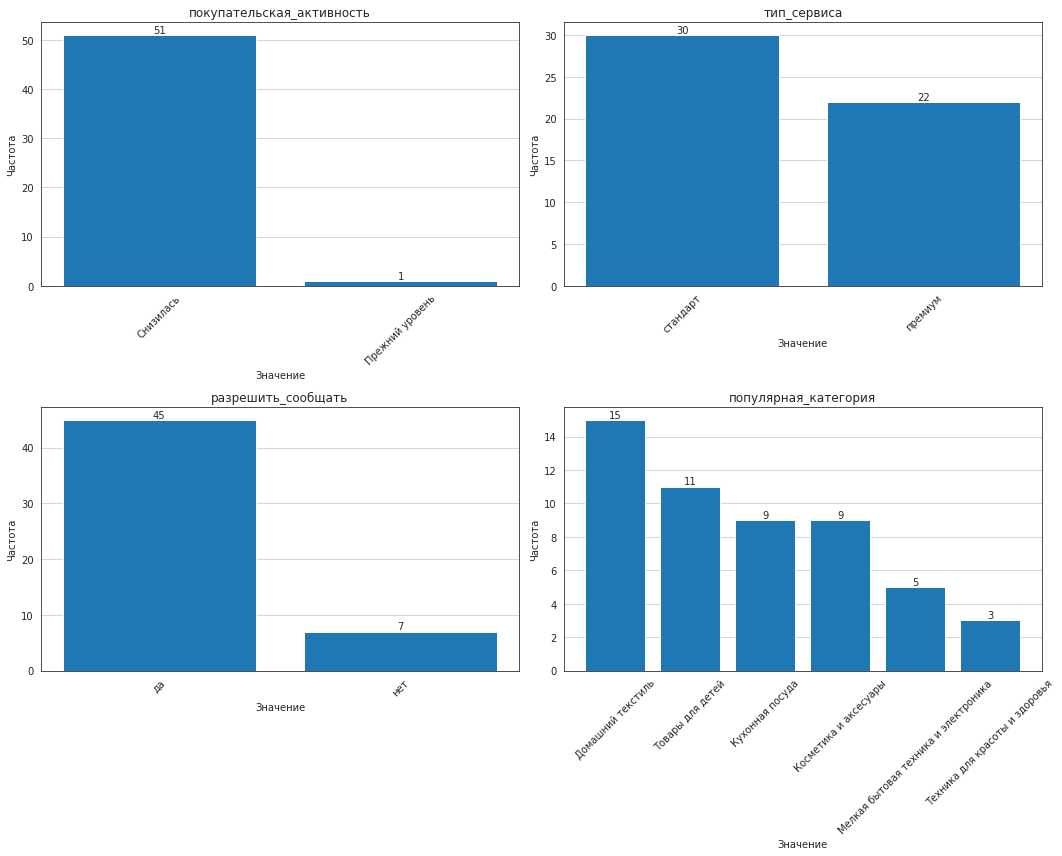

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

axes = axes.flatten()

for i, column in enumerate(column_names_cat):
    ax = axes[i]
    bar_data = df_merged_segment[column].value_counts()
    ax.bar(bar_data.index, bar_data.values)
    for index, value in zip(bar_data.index, bar_data.values):
        ax.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
    ax.set_title(column)
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')
    ax.tick_params(axis='x', labelrotation=45)
    ax.grid(axis='y')

plt.tight_layout()
plt.show()

1. Видим, что канал коммуникации с клиентами открыт (87% клиентов разрешают присылать сообщения).
2. Доля пользователей премиум подписки от всех клиентов 42% в сегменте - это на 8% выше, чем в целом среди теряющих активность. Очень важный сигнал для того, чтобы условия подписки сделать более привлекательными и полезными.
3. Здесь в топ-3 популярных категорий товары для дома (текстиль и посуда) и товары для детей. Это надо учитывать в следующих меркетинговых кампаний.

### Время на сайте

In [ ]:
# создаем датафрейм для анализа распределения времени по периодам
df_time_segment = df_time[df_time['id'].isin(segment['id'])]

display(df_time_segment.head())

,id,период,минут
6,215351,текущий_месяц,13
7,215351,предыдущий_месяц,11
10,215353,предыдущий_месяц,10
11,215353,текущий_месяц,10
12,215354,предыдущий_месяц,11


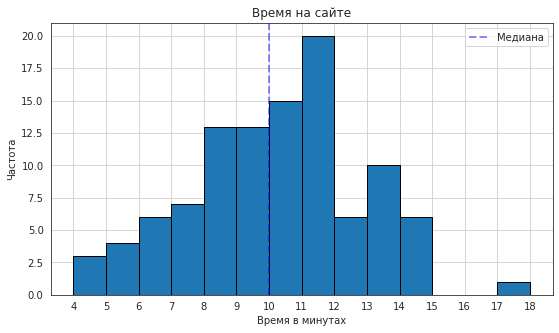

In [ ]:
min_val = int(df_time_segment['минут'].min())
max_val = int(df_time_segment['минут'].max()) + 2

bin_edges = np.arange(min_val, max_val, 1)

plt.figure(figsize=(9, 5))
plt.hist(df_time_segment['минут'], bins=bin_edges, edgecolor='black')
plt.axvline(df_time_segment['минут'].median(), 
         color='blue', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана')
plt.xlabel('Время в минутах')
plt.ylabel('Частота')
plt.title('Время на сайте')
plt.grid()
plt.legend()
plt.xticks(bin_edges)
plt.show()

Медиана времени на сайте 10 минут, как и у группы со снижающейся активностью в целом, у активных 15 минут.

### Прибыль

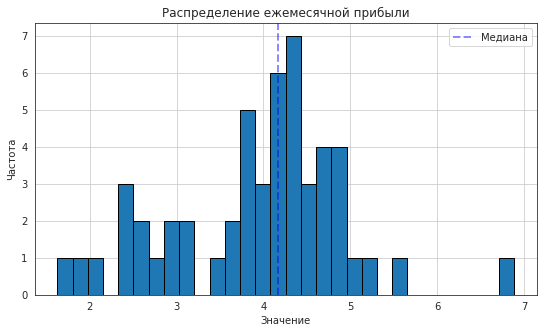

In [ ]:
df_monthly_profit_segment = df_monthly_profit[df_monthly_profit['id'].isin(segment['id'])]

plt.figure(figsize=(9, 5))
plt.hist(df_monthly_profit_segment['прибыль'], bins=30, edgecolor='black')
plt.axvline(df_monthly_profit_segment['прибыль'].median(), 
         color='blue', 
         alpha=0.45, 
         linestyle='--', 
         linewidth=2, 
         label=f'Медиана')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение ежемесячной прибыли')
plt.legend()
plt.grid()
plt.show()

Уровень приносимой прибыли примерно такой же, как и в двух других группах.

### Выручка

In [ ]:
# создаем датафрейм для анализа распределения выручки по периодам
df_money_segment = df_money[df_money['id'].isin(segment['id'])]

display(df_money_segment.head())

,id,период,выручка
9,215351,текущий_месяц,6610.4
10,215351,предыдущий_месяц,6158.0
11,215351,предпредыдущий_месяц,4793.0
15,215353,предыдущий_месяц,4738.5
16,215353,предпредыдущий_месяц,5124.0


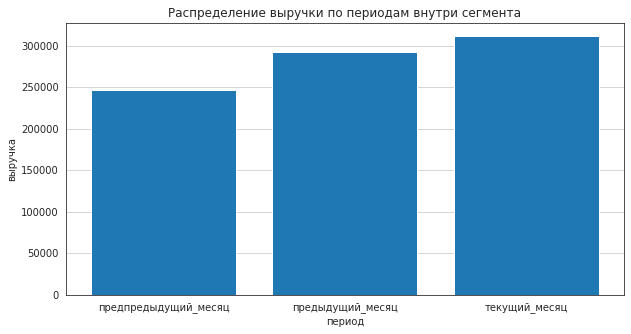

In [ ]:
money_dinamic = df_money_segment.groupby('период')['выручка'].sum()

plt.figure(figsize=(10, 5))
plt.bar(money_dinamic.index, money_dinamic.values)
plt.xlabel('период')
plt.ylabel('выручка')
plt.title('Распределение выручки по периодам внутри сегмента')
plt.grid(axis='y')
plt.show()

Мы видим, что, несмотря на явное снижение вовлеченности и активности на сайте, покупательская активность этих клиентов от месяца к месяцу растет.

Это может объясняться знанием асортимента, привычкой покупать знакомые товары и нежеланием искать что-то новое. Такое поведение, в целом, свойственно старым и лояльным покупателям. Это подтверждается данными о времени регистрации.

Плюс мы уже заметили, что число маркетинговых коммуникаций с клиентами в текущем месяце выросло по сравнению с 6-ю последними месяцами. Этот рост ожидаемо привел к увеличению выручки.

### Выводы о сегменте

**Портрет покупателей из выбранного сегмента**

Неожиданно эти клиенты оказалась не теми, кем мы их сначала считали: это лояльные и активные покупатели. Их поведение - не признак ухода, а признак изменившейся, более эффективной модели совершения покупок.

1. Финансово активны и растут.

Несмотря на низкую вовлеченность, выручка от этого сегмента растет от месяца к месяцу. Это ключевой инсайт: их покупательская активность не падает, а реализуется более точечно. Они приносят столько же прибыли, сколько и активные клиенты, поэтому их удержание — приоритет.

2. Чувствительны к акциям. 

Это самая яркая черта. В среднем 60% их покупок — акционные. Они не бродят по сайту в поисках чего-то нового, а ждут выгодного предложения и целенаправленно его используют.

2. Низкая вовлеченность не означает потерю интереса. 

Их низкие показатели (мало просмотренных страниц и категорий, мало времени на сайте) - это не недостаток, а особенность. Это значит, что они точно знают, за чем пришли. Они заходят на сайт, чтобы совершить конкретную покупку, и уходят.

3. Лояльные старожилы. 

Это лояльные клиенты, которые давно с магазином. Крайне важно, что 87% из них разрешили присылать им сообщения. У нас есть прямой и одобренный канал коммуникации с ними.

4. Премиум-подписчики. 

В этом сегменте аномально высокая доля (42%) клиентов с премиум-подпиской. Это парадокс: самые "невовлеченные" клиенты платят за премиум-статус. Вероятно, текущие преимущества подписки не мотивируют их к исследованию сайта.

**Рекомендации по взаимодействию с этой категорией**

1. Поддержание высокого уровня маркетинговой коммуникации.

Данные подтверждают, что с увеличением взаимодействия с этими клиентами растет и их выручка.

2. Персонализированные предложения.

Предлагать скидки на самые популярные категории конкретного клиента.

3. Повышение чека покупки

Покупатели из этого сегмента хорошо реагируют на акции и, судя по растущей выручке, имеют возможность покупать больше. Можно стимулировать их к этому акциями типа "2 по цене одного", предложением сопутствующих товаров или товаров регулярного спроса.

4. Борьба с брошенными корзинами.

Проанализировать процесс оформления заказа и устранить возможные трудности, с которыми сталкиваются клиенты (например, необходимость каждый раз заново привязывать карту).

Предоставить возможность постоплаты.

Мотивировать быстрее оплачивать товары в корзине с помощью бонусов, ограниченных по времени (например, скидок на доставку).

5. Изменение условий подписки.

Проанализировать, какими преимуществами подписки пользуются клиенты: возможно какие-то ее предложения уже устарели. 

Для бизнеса также может быть полезна работа с сегментом активных, но приносящих мало выручки: они уже вовлечены, но что-то мешает им покупать. По ним в будущем можно будет провести отдельное исследование.

## Общий вывод

В рамках проекта была решена задача по анализу и прогнозированию снижения покупательской активности клиентов интернет-магазина «В один клик». Была разработана модель машинного обучения, проведен анализ ключевых факторов, влияющих на поведение пользователей, и предложена стратегия по работе с клиентами на основе сегментации.

**Ключевые этапы работы**

1. Подготовка и предобработка данных 

Были загружены и изучены 4 датасета. Унифицированы названий столбцов, устранены неявные дубликаты и опечатки.

2. Исследовательский анализ 

Проведен сравнительный анализ признаков клиентов из двух групп - активных пользователей и теряющих активность. Обнаружены важные поведенческие паттерны, например, наличие двух групп пользователей: ориентированных на акции и совершающих регулярные покупки.

3. Моделирование 

Для прогнозирования снижения активности были протестированы 4 модели (LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, SVC) с различными методами кодирования и масштабирования признаков. Для этого использовался метод пайплайна.

**Лучшей моделью** по итогам тестирования оказалась SVC (Support Vector Classifier).

Модель показала высокое качество прогнозирования: метрика ROC-AUC составила 0.91 на кросс-валидации и 0.91 на тестовой выборке. Это говорит о том, что модель способна с высокой точностью отличать клиентов, склонных к снижению активности, от стабильных.

4. Анализ важности признаков 

Анализ с помощью метода SHAP позволил определить, какие факторы наиболее сильно влияют на предсказание модели.

Самые важные признаки связаны с поведенческой вовлеченностью:
- страниц за визит: это ключевой показатель вовлеченности;
- минут предыдущий/текущий месяц: показывает активность на сайте;
- средний просмотр категорий за визит: насколько глубоко пользователь изучает ассортимент;
- акционные покупки: как часто пользователь участвовал в акциях;
- неоплаченные покупки: сколько товаров клиент бросил в корзине неоплаченными.
Наименее значимые признаки включали:
- популярные категории
- маркетинговая активность в текущем месяце
- выручка предыдущий/текущий месяц. 

Это означает, что то, как пользователь взаимодействует с сайтом, важнее для прогноза оттока, чем то, ЧТО он смотрит или сколько принес выручки.

5. Сегментация клиентов и рекомендации для бизнеса

На основе данных модели и прибыльности был выделен сегмент покупателей в зоне риска, нуждающихся в удержании, - это клиенты с высокой выручкой, но теряющие активность.

**Портрет клиентов** из этого сегмента:
- Финансово активны и растут.
Несмотря на низкую вовлеченность, выручка от этого сегмента растет от месяца к месяцу. 

- Чувствительны к акциям.
Это самая яркая черта. В среднем 60% их покупок — акционные.

- Низкая вовлеченность не означает потерю интереса.
Их низкие показатели (мало просмотренных страниц и категорий, мало времени на сайте) - это не недостаток, а особенность. 

- Лояльные старожилы.
Это лояльные клиенты, которые давно с магазином.

- Премиум-подписчики.
В этом сегменте аномально высокая доля (42%) клиентов с премиум-подпиской. 

**Ключевой вывод** после анализа этого сегмента: снижение активности — это не уход, а рост эффективности.

**Рекомендации** по работе с сегментом:
- Поддержание высокого уровня маркетинговой коммуникации.

Данные подтверждают, что с увеличением взаимодействия с этими клиентами растет и их выручка.
- Персонализированные предложения.

Предлагать скидки на самые популярные категории конкретного клиента.
- Повышение чека покупки

Покупатели из этого сегмента хорошо реагируют на акции и, судя по растущей выручке, имеют возможность покупать больше. Можно стимулировать их к этому акциями типа "2 по цене одного", предложением сопутствующих товаров или товаров регулярного спроса.
- Борьба с брошенными корзинами.

Проанализировать процесс оформления заказа и устранить возможные трудности, с которыми сталкиваются клиенты (например, необходимость каждый раз заново привязывать карту).

Предоставить возможность постоплаты.

Мотивировать быстрее оплачивать товары в корзине с помощью бонусов, ограниченных по времени (например, скидок на доставку).
- Изменение условий подписки.

Проанализировать, какими преимуществами подписки пользуются клиенты: возможно какие-то ее предложения уже устарели.

6. Заключение 

Проект продемонстрировал, как с помощью анализа данных и машинного обучения можно не только построить точную прогнозную модель для анализа активности клиентов, но и получить важную для бизнеса информацию. 

Анализ данных позволяет перейти от борьбы с обобщенной проблемой «оттока» к эффективной работе с конкретным сегментом. Вместо того чтобы пытаться изменить поведение клиентов, предложенная стратегия фокусируется на удовлетворении их реальных потребностей, что с высокой вероятностью приведет к их удержанию и росту общей прибыльности интернет-магазина.